In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import output_processing as op
from functools import reduce
import prompts

/Users/ab-purushothama-macbook/.conda/envs/prej-prompt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
models= [
    "meta-llama/Llama-3.2-1B",
    "meta-llama/Llama-3.2-1B-Instruct",
    "meta-llama/Llama-3.2-3B",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.1-8B",
    "meta-llama/Llama-3.1-8B-Instruct",
    "gpt2-large",
    "allenai/OLMo-2-1124-7B-Instruct",
    "mistralai/Ministral-8B-Instruct-2410",
    "google/gemma-7b-it"
]
def read_and_organize_model_results(model_name):
    model_results = pd.read_csv(f"runs/runs-1001-05_19/{model_name}-results.csv")
    model_results.replace([0.0], -65504, inplace=True)
    model_results = op.organize_distribution(model_results)
    model_results["model_name"] = model_name.split("/")[-1]
    return model_results
    
combined_results = [read_and_organize_model_results(model_name) for model_name in models]
combined_df = pd.concat(combined_results).reset_index()
combined_df.shape

(9936, 23)

# Analysis with Answer Choice

In [3]:
np.sum(combined_df["Aff_prob"] > combined_df["UnAff_prob"])/combined_df.shape[0]

np.float64(0.5341183574879227)

In [4]:
combined_df.sample()

,index,title,prompt_type,prompt,version,output,output_text,cum_logprob,Yes_probs,No_probs,...,Aff_prob,UnAff_prob,Covered_prob,NotCovered_prob,Covered,NotCovered,Answer,Answer_prob,entropy,model_name
5926,958,Vehicle Theft VI,disagreement_negation,Cooper's car insurance policy includes coverag...,unambiguous_covered,Final,Final answer is: Final answer is: Final answe...,NaN,0.15828,0.108784,...,0.15828,0.108784,0.592667,0.407333,True,False,Covered,0.592667,0.760819,Llama-3.1-8B


In [5]:
combined_df.groupby(['prompt_type'], as_index=False, sort=False).apply(lambda x: x.Covered.sum()) 

/var/folders/9g/y4xr1pr156905g16w5kjh4qh0000gn/T/ipykernel_43699/3110038544.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df.groupby(['prompt_type'], as_index=False, sort=False).apply(lambda x: x.Covered.sum())


,prompt_type,None
0,yes_or_no,678
1,no_or_yes,369
2,negation,330
3,agreement,910
4,agreement_negation,778
5,disagreement,413
6,disagreement_negation,358
7,options,559
8,options_flipped,912


In [6]:
combined_df.sample().Covered

3101    True
Name: Covered, dtype: bool

# Percentage answer as 'Covered'

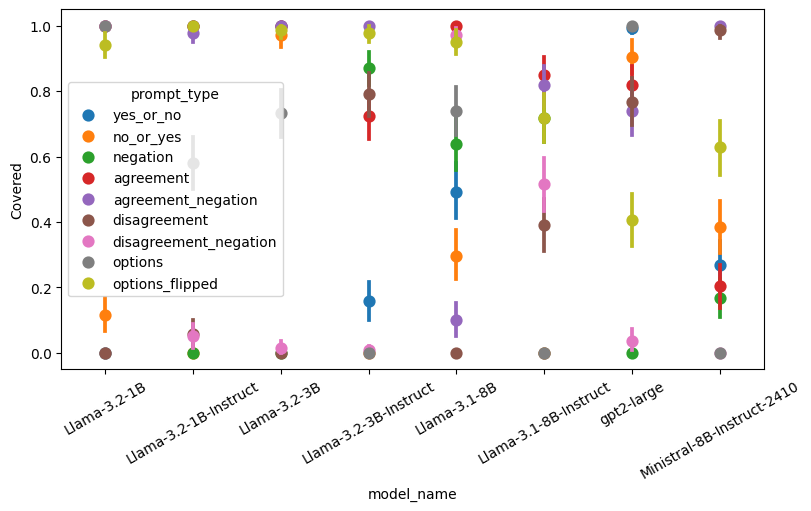

In [7]:
VAGUE_CONTRACTS_SIZE=138
fig, ax = plt.subplots(1,1, figsize=(8,5), layout='constrained')
plt.xticks(rotation=30)
point_plot = sns.pointplot(
    data = combined_df,
    x='model_name',
    y='Covered',
    hue='prompt_type',
    linestyle='None'
)
# fig = point_plot.get_figure()
# fig.savefig("fig-covered-count-models.pdf", format="pdf")

## Answer 'covered' by prompt type

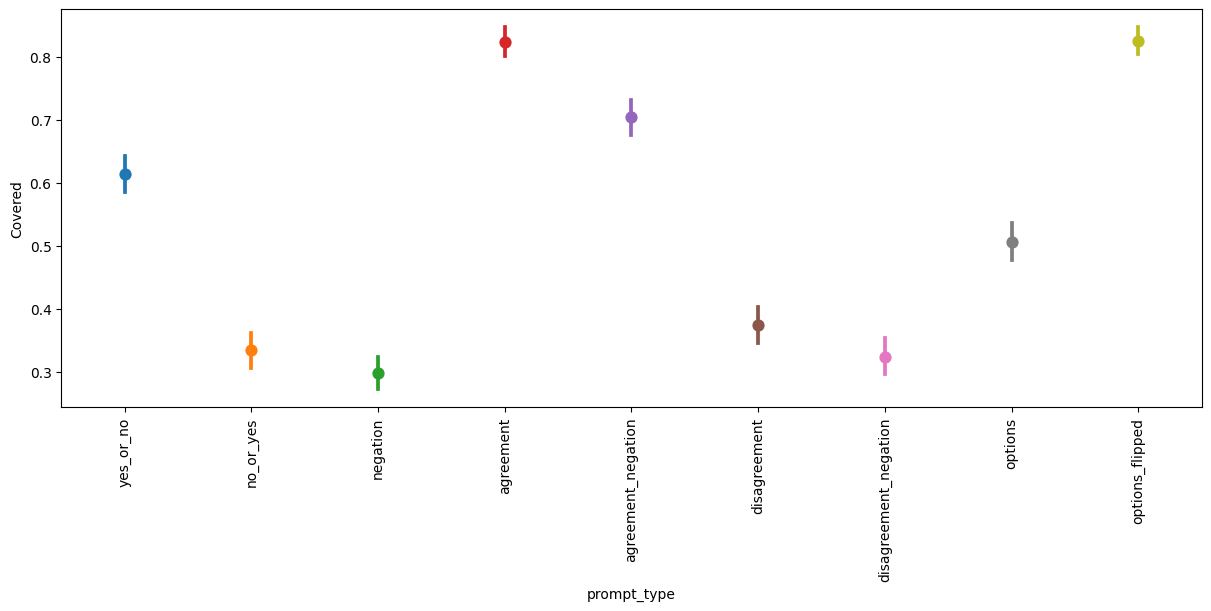

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = combined_df,
    x='prompt_type',
    y='Covered',
    hue='prompt_type',
    linestyle="None"
)
# fig = point_plot.get_figure()
# fig.savefig("fig-covered-by-model-and-prompts.pdf", format="pdf")

## 'Covered' by item (totally on all models) [Not very useful]

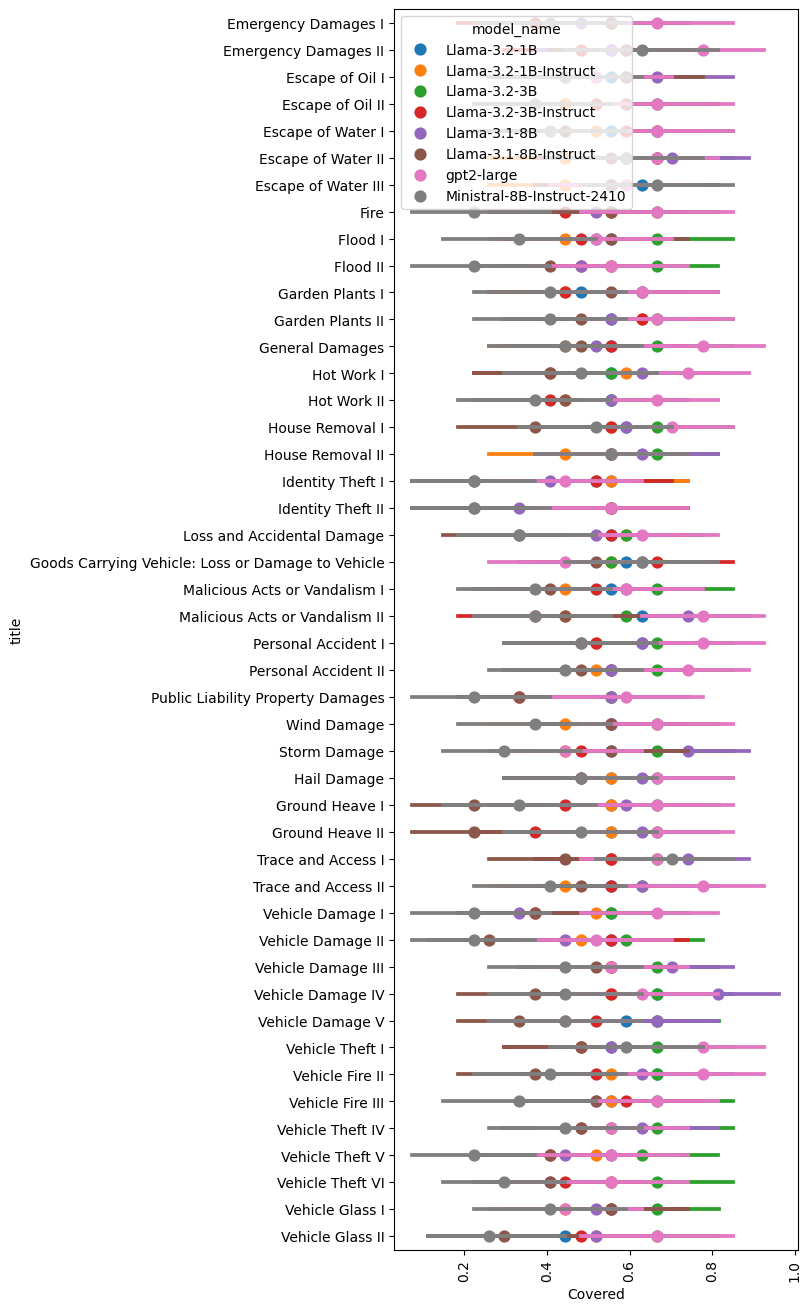

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = combined_df,
    x='Covered',
    y='title',
    hue='model_name',
    linestyle="None",
    # dodge=.8 - .8 / 8
)

## Covered by item (two models only) [Just a bit more useful]

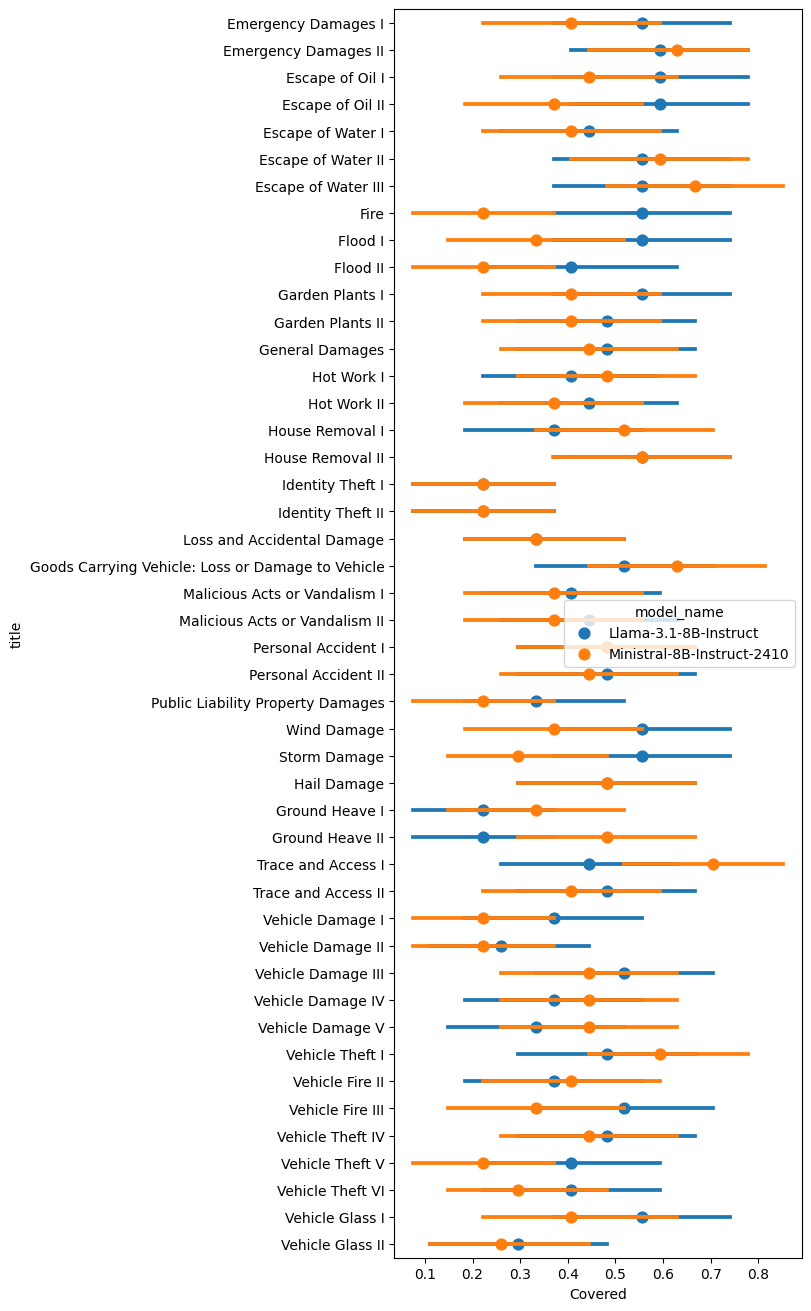

In [10]:
selected_models = ["Ministral-8B-Instruct-2410", "Llama-3.1-8B-Instruct"]
selected_df = combined_df[combined_df["model_name"].isin(selected_models)]

fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
point_plot = sns.pointplot(
    data = selected_df,
    x='Covered',
    y='title',
    hue='model_name',
    linestyle="None",
)

# Analysis with relative measures

In [11]:
relative_measures = op.calculate_relative_measures(combined_df)
relative_measures.js_dist.unique()

array([0.05296124, 0.08719652, 0.34957016, ..., 0.04590675, 0.33515636,
       0.23093642])

# Jennsen Shannon Distance

## Model wise distances by prompt type

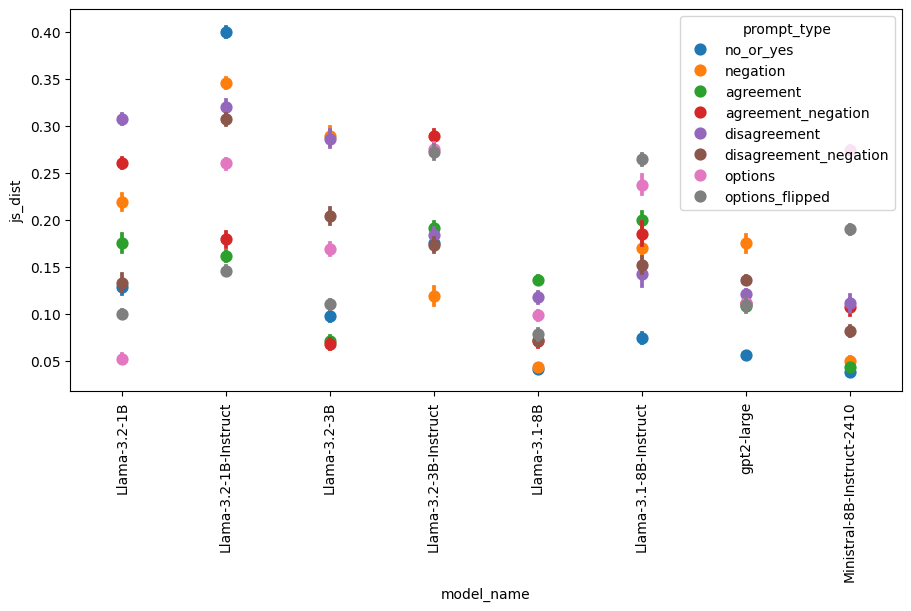

In [12]:
fig, ax = plt.subplots(1,1, figsize=(9,6), layout='constrained')
plt.xticks(rotation=90)
dist_plot_for_models = sns.pointplot(
    data=relative_measures, x='model_name', y ='js_dist', hue='prompt_type', linestyle='None')

## Distance variance by prompt type

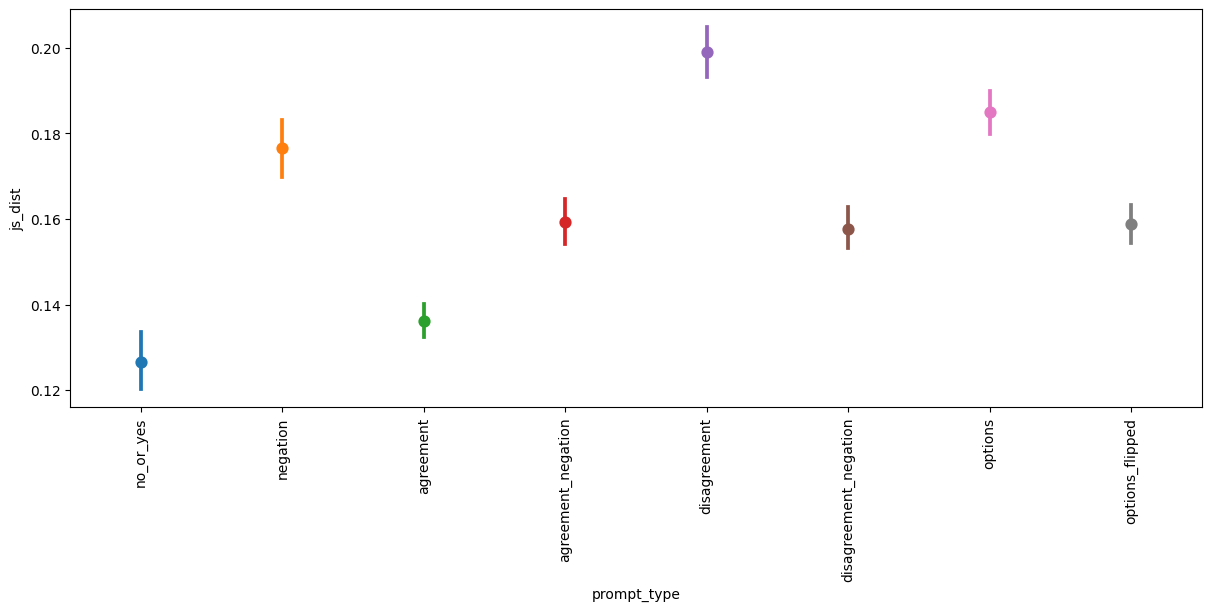

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = relative_measures,
    x='prompt_type',
    y='js_dist',
    hue='prompt_type',
    linestyle="None"
)
# fig = point_plot.get_figure()

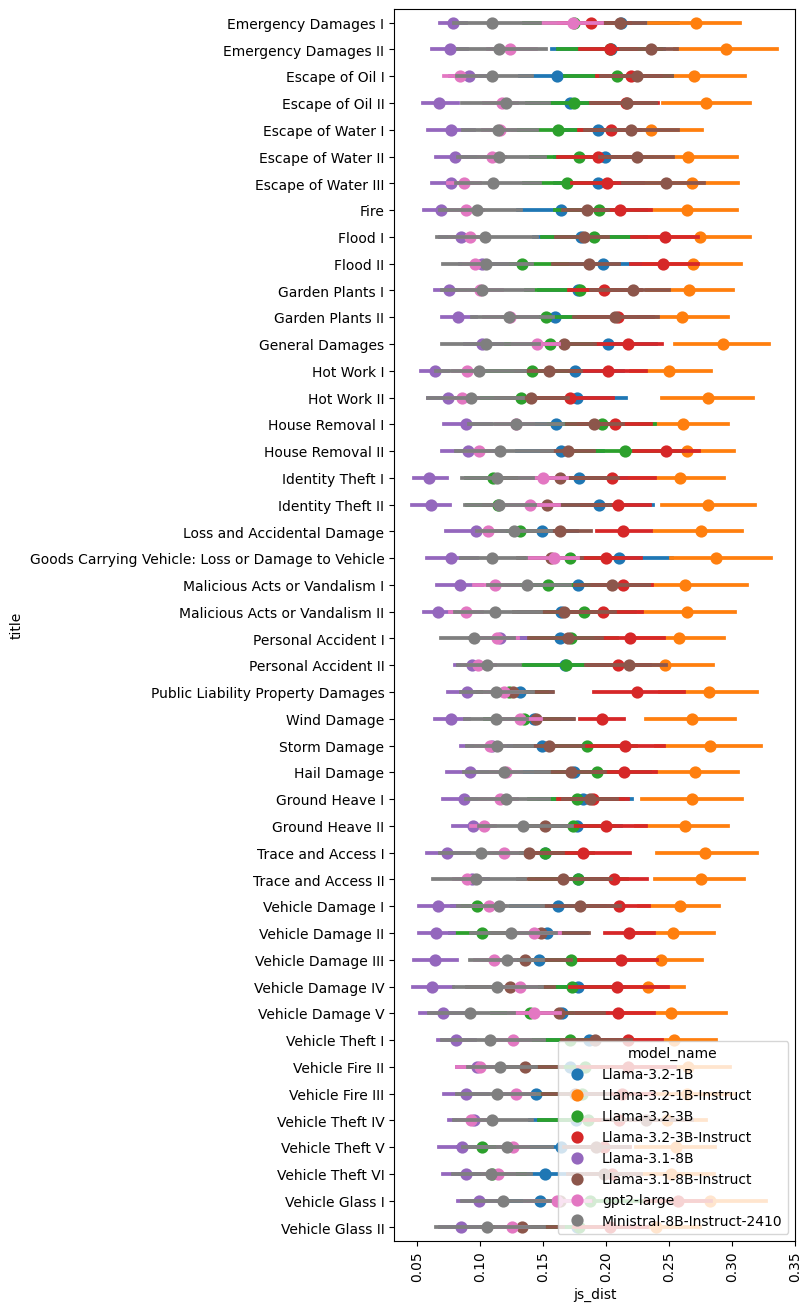

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = relative_measures,
    x='js_dist',
    y='title',
    hue='model_name',
    linestyle="None",
    # dodge=.8 - .8 / 8
)

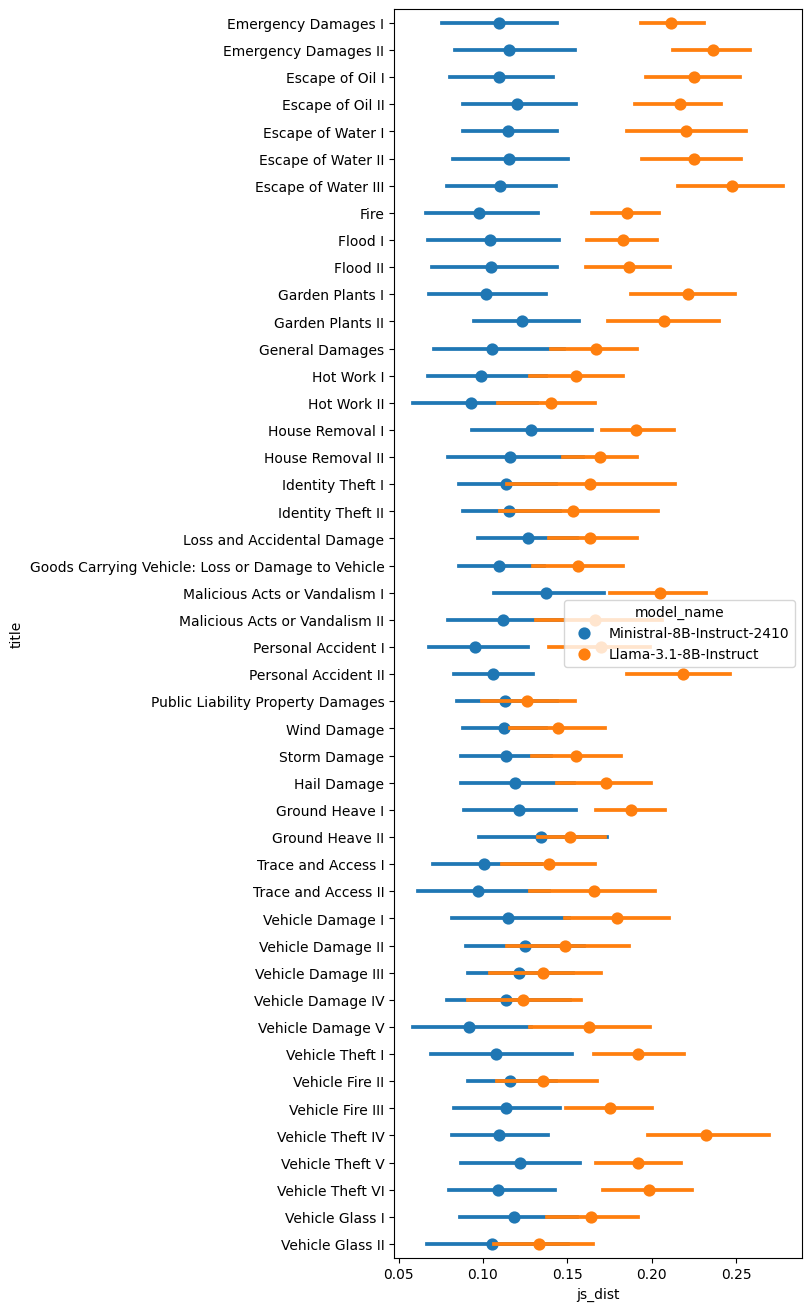

In [15]:
selected_models = ["Ministral-8B-Instruct-2410", "Llama-3.1-8B-Instruct"]
selected_df = relative_measures[relative_measures["model_name"].isin(selected_models)]

fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
point_plot = sns.pointplot(
    data = selected_df,
    x='js_dist',
    y='title',
    hue='model_name',
     hue_order=selected_models,
    linestyle="None",
)

# Conditional Entropy

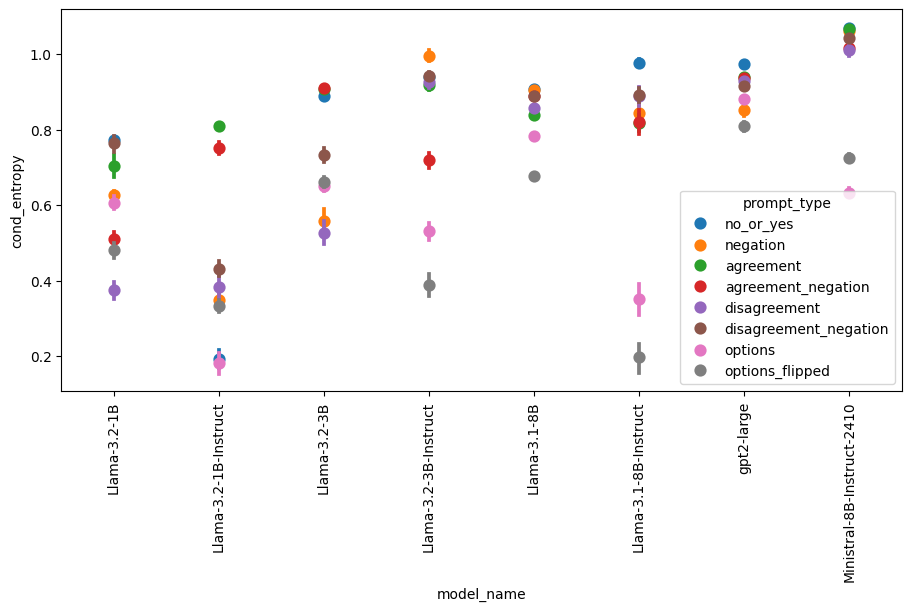

In [16]:
fig, ax = plt.subplots(1,1, figsize=(9,6), layout='constrained')
plt.xticks(rotation=90)
dist_plot_for_models = sns.pointplot(
    data=relative_measures, x='model_name', y ='cond_entropy', hue='prompt_type', linestyle='None')

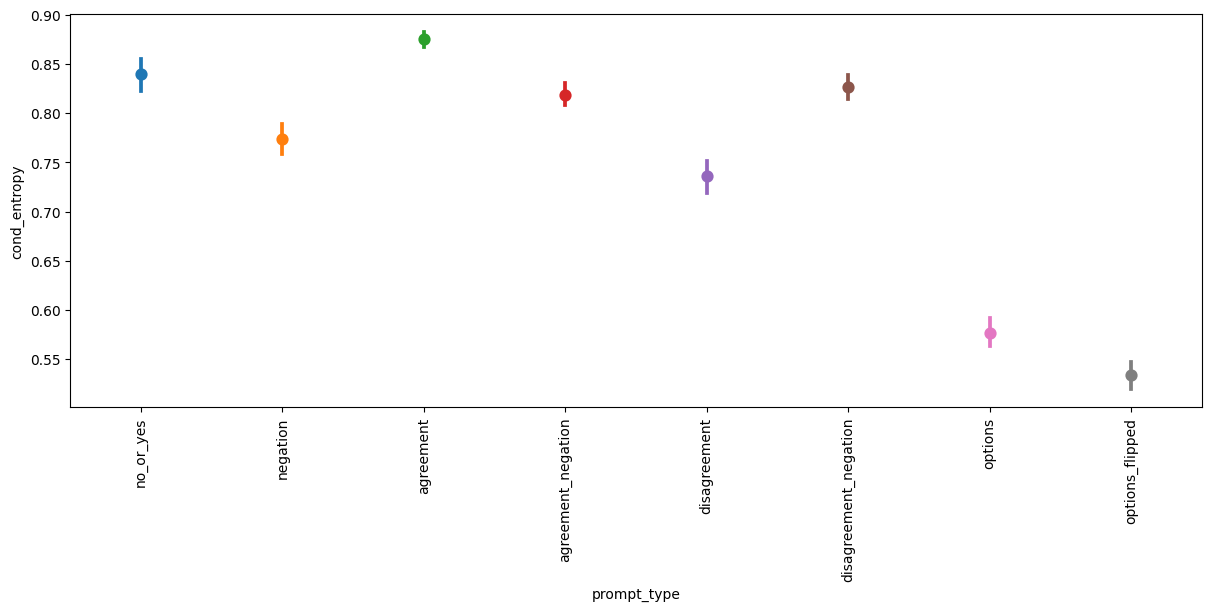

In [17]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = relative_measures,
    x='prompt_type',
    y='cond_entropy',
    hue='prompt_type',
    linestyle="None"
)
# fig = point_plot.get_figure()

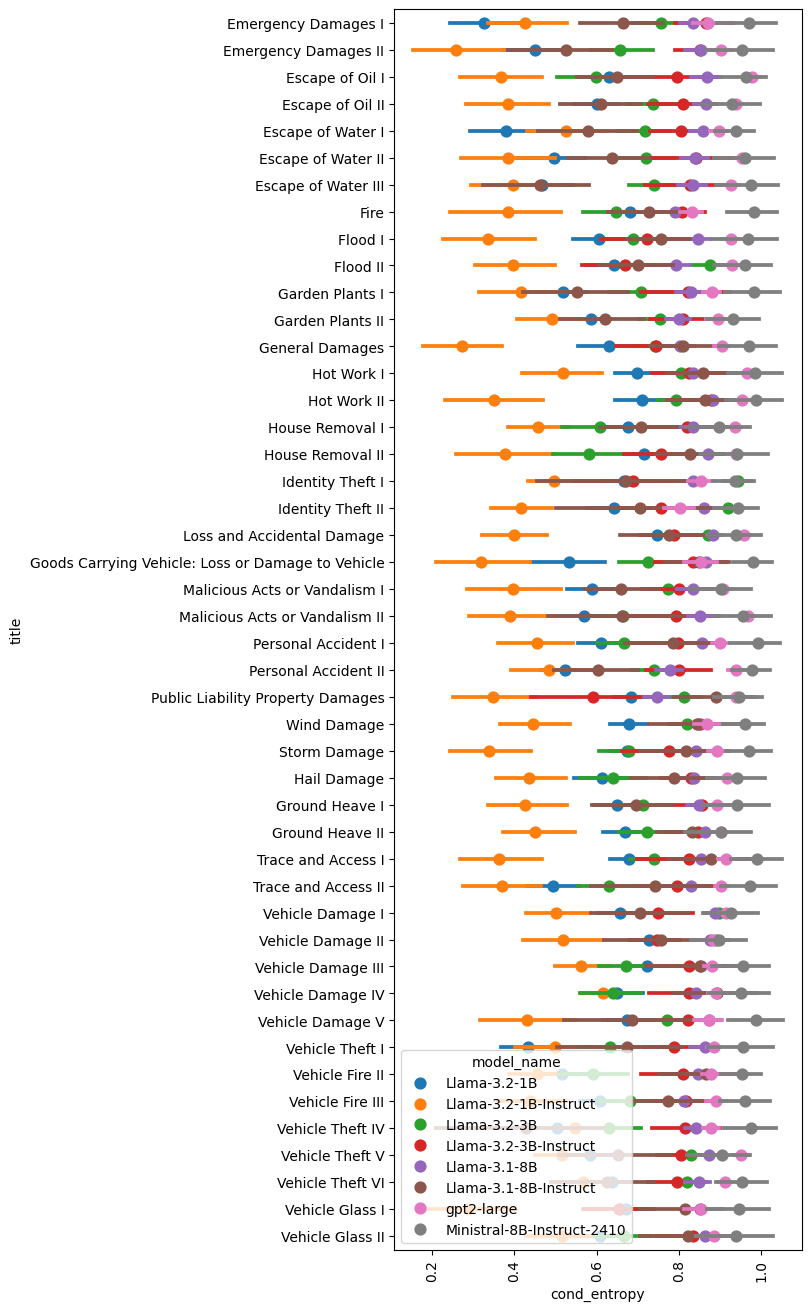

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = relative_measures,
    x='cond_entropy',
    y='title',
    hue='model_name',
    linestyle="None",
    # dodge=.8 - .8 / 8
)

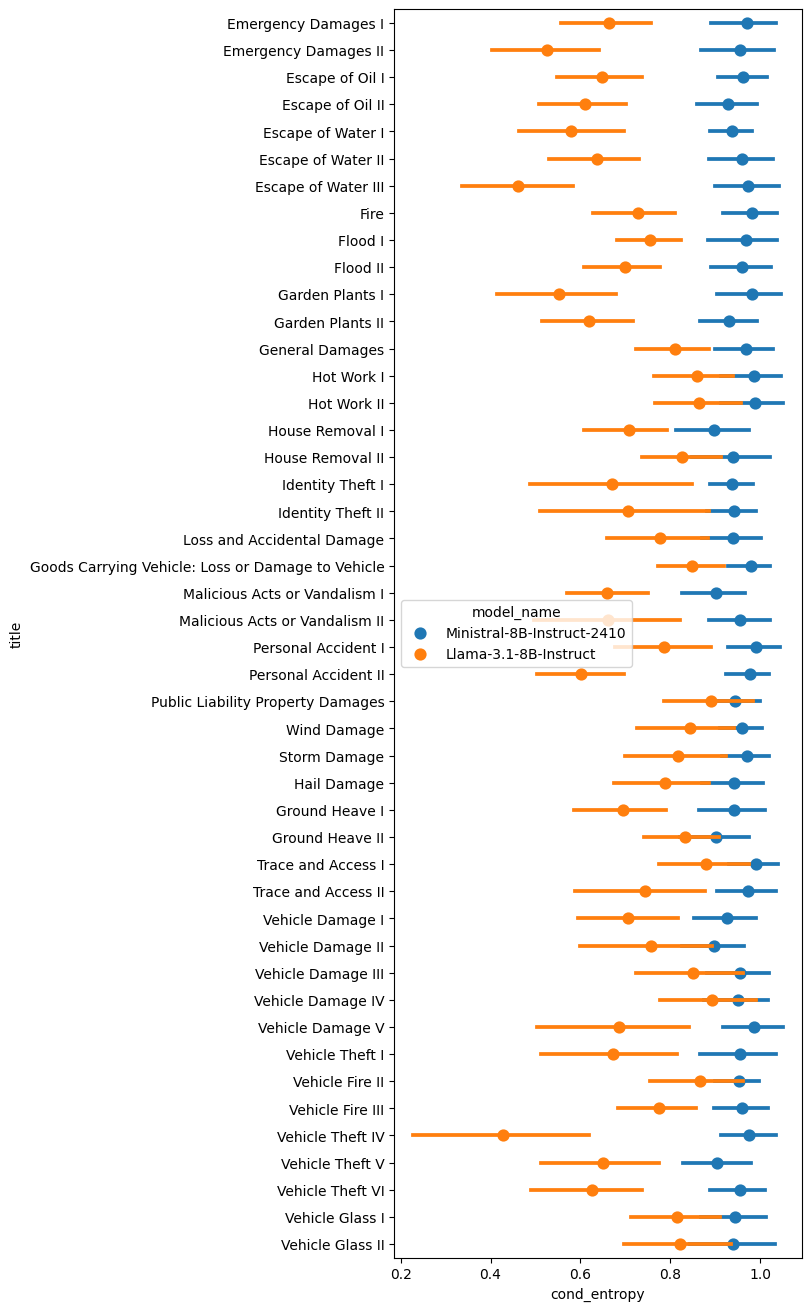

In [19]:
selected_models = ["Ministral-8B-Instruct-2410", "Llama-3.1-8B-Instruct"]
selected_df = relative_measures[relative_measures["model_name"].isin(selected_models)]

fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
point_plot = sns.pointplot(
    data = selected_df,
    x='cond_entropy',
    y='title',
    hue='model_name',
    hue_order=selected_models,
    linestyle="None",
)

# Majority Votes (per-title+version, per-model, aggregates over prompt type)

In [32]:
item_measures = op.calculate_item_measures(combined_df)
item_measures.columns

Index(['title', 'version', 'model_name', 'Answer_Mode', 'Answer_Votes',
       'Answer_Prob'],
      dtype='object')

In [21]:
item_measures["name"] = item_measures["title"] + " " + item_measures["version"]

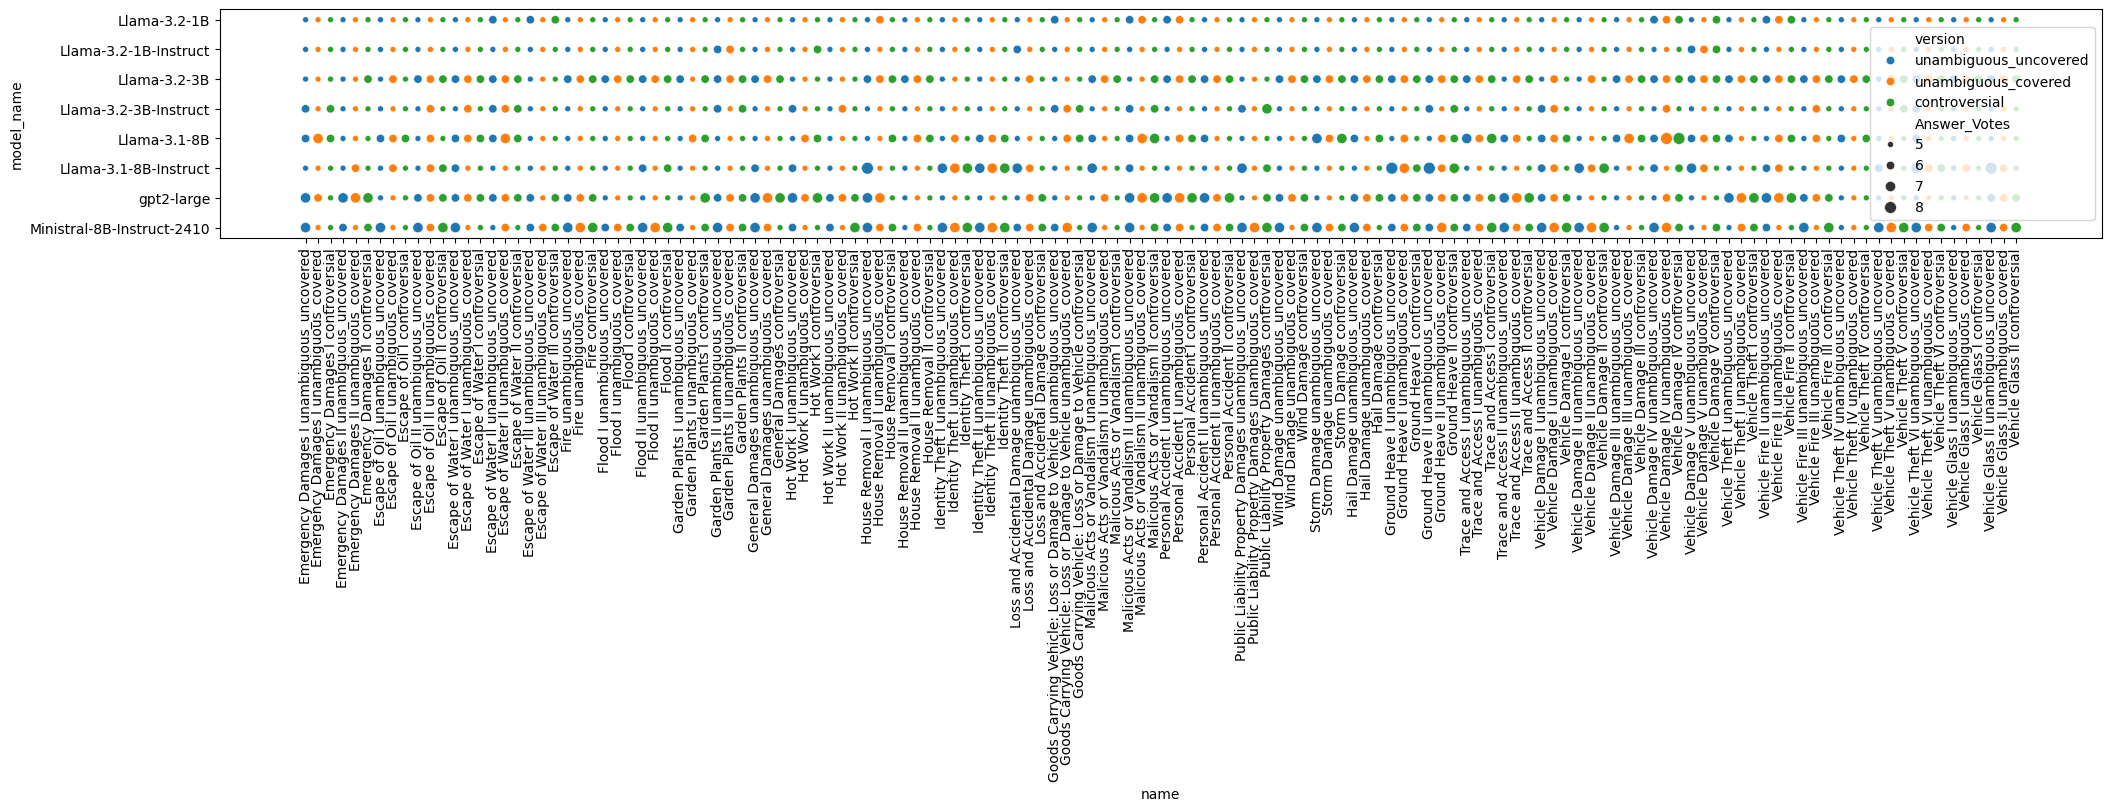

In [22]:
fig, ax = plt.subplots(1,1, figsize=(21,8), layout='constrained')
plt.xticks(rotation=90)
g = sns.scatterplot(
    x='name',
    y='model_name',
    hue="version",
    size="Answer_Votes",
    data=item_measures)         

<Axes: xlabel='model_name', ylabel='Answer_Votes'>

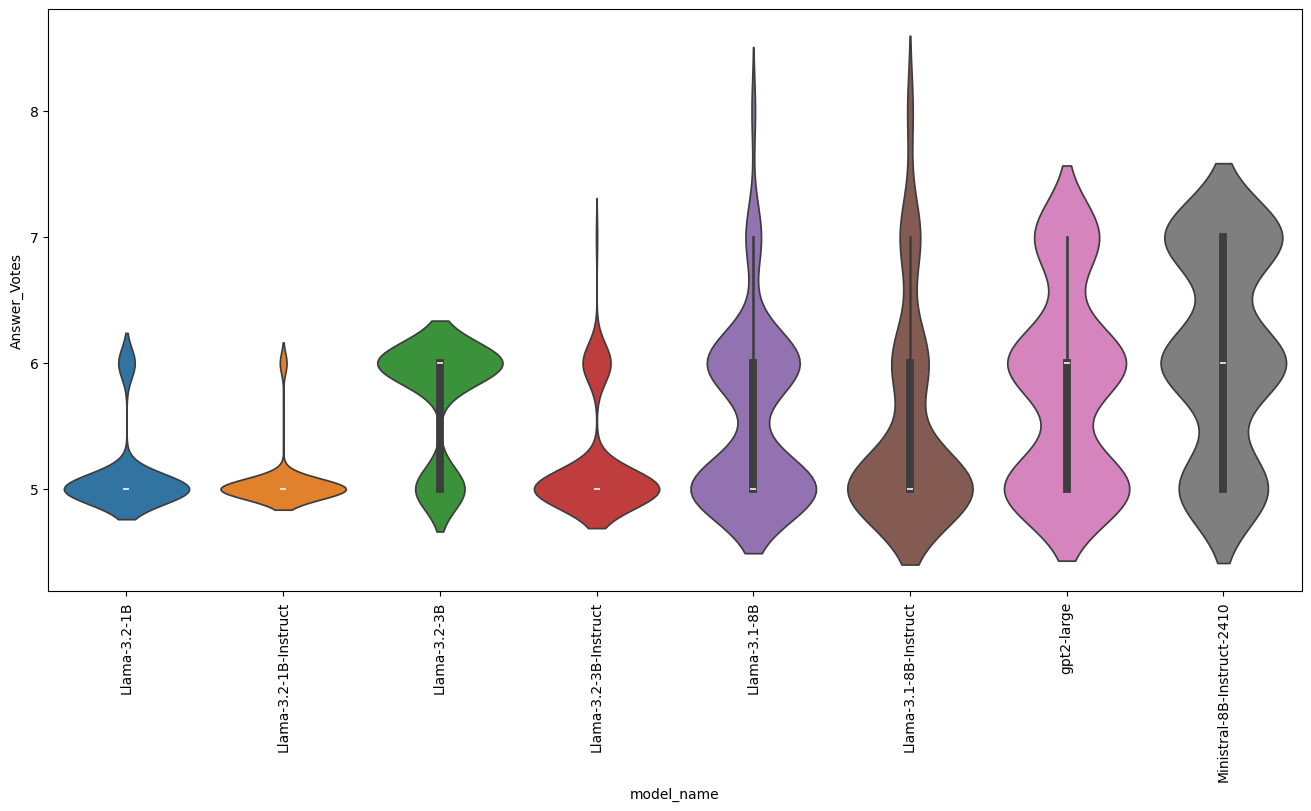

In [23]:
fig, ax = plt.subplots(1,1, figsize=(13,8), layout='constrained')
plt.xticks(rotation=90)
sns.violinplot(
    y='Answer_Votes',
    x='model_name',
    hue="model_name",
    data=item_measures,
    density_norm='count')         

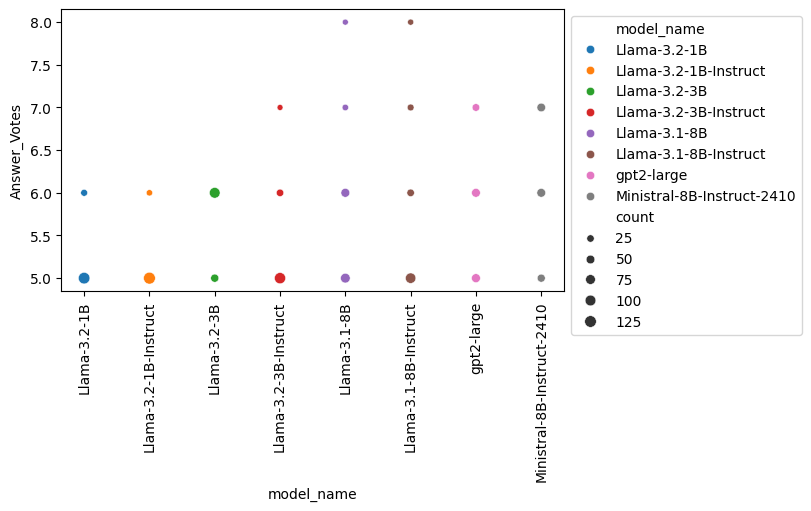

In [33]:
fig, ax = plt.subplots(1,1, figsize=(8,5), layout='constrained')
plt.xticks(rotation=90)
ax = sns.scatterplot(
    y='Answer_Votes',
    x='model_name',
    hue="model_name",
    size='count',
    data=item_measures.groupby(['model_name', 'Answer_Votes'], sort=False, as_index=False).agg(count=pd.NamedAgg(column='Answer_Votes', aggfunc='count'))
)
sns.move_legend(ax, "upper left",  bbox_to_anchor=(1, 1))

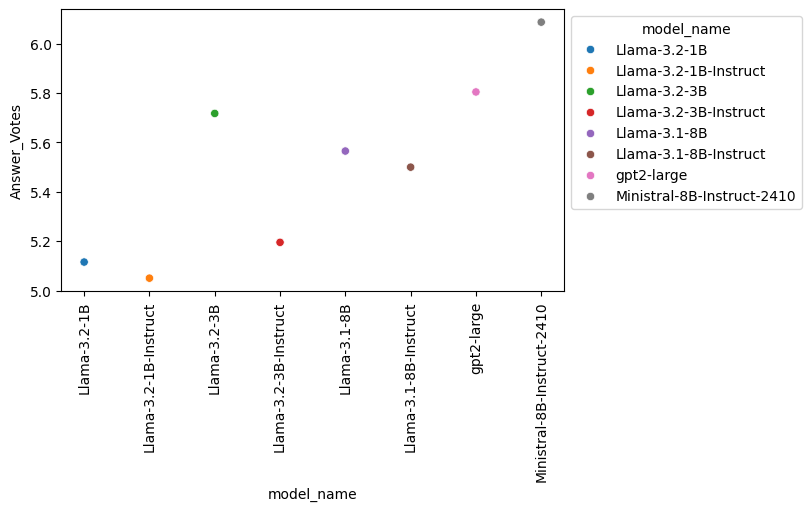

In [37]:
fig, ax = plt.subplots(1,1, figsize=(8,5), layout='constrained')
plt.xticks(rotation=90)
ax = sns.scatterplot(
    y='Answer_Votes',
    x='model_name',
    hue="model_name",
    data=item_measures.groupby(['model_name'], sort=False, as_index=False).agg({'Answer_Votes': 'mean'})
)
sns.move_legend(ax, "upper left",  bbox_to_anchor=(1, 1))

In [46]:
item_measures

,title,version,model_name,Answer_Mode,Answer_Votes,Answer_Prob
0,Emergency Damages I,unambiguous_uncovered,Llama-3.2-1B,Covered,5,0.681221
1,Emergency Damages I,unambiguous_covered,Llama-3.2-1B,Covered,5,0.689016
2,Emergency Damages I,controversial,Llama-3.2-1B,Covered,5,0.691620
3,Emergency Damages II,unambiguous_uncovered,Llama-3.2-1B,Covered,5,0.715439
4,Emergency Damages II,unambiguous_covered,Llama-3.2-1B,Covered,5,0.699557
...,...,...,...,...,...,...
1099,Vehicle Glass I,unambiguous_covered,Ministral-8B-Instruct-2410,NotCovered,6,0.591544
1100,Vehicle Glass I,controversial,Ministral-8B-Instruct-2410,NotCovered,5,0.614691
1101,Vehicle Glass II,unambiguous_uncovered,Ministral-8B-Instruct-2410,NotCovered,7,0.651131
1102,Vehicle Glass II,unambiguous_covered,Ministral-8B-Instruct-2410,NotCovered,6,0.575185


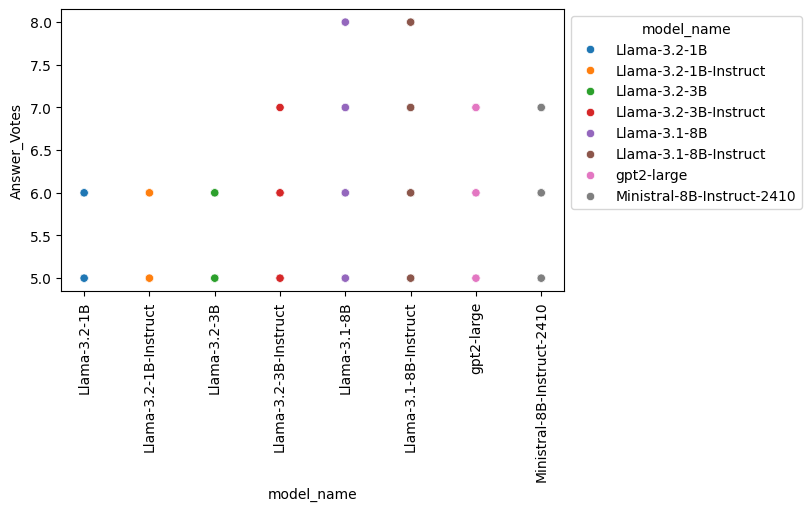

In [39]:
fig, ax = plt.subplots(1,1, figsize=(8,5), layout='constrained')
plt.xticks(rotation=90)
ax = sns.scatterplot(
    y='Answer_Votes',
    x='model_name',
    hue="model_name",
    data=item_measures
)
sns.move_legend(ax, "upper left",  bbox_to_anchor=(1, 1))

# Probability as confidence on the vote

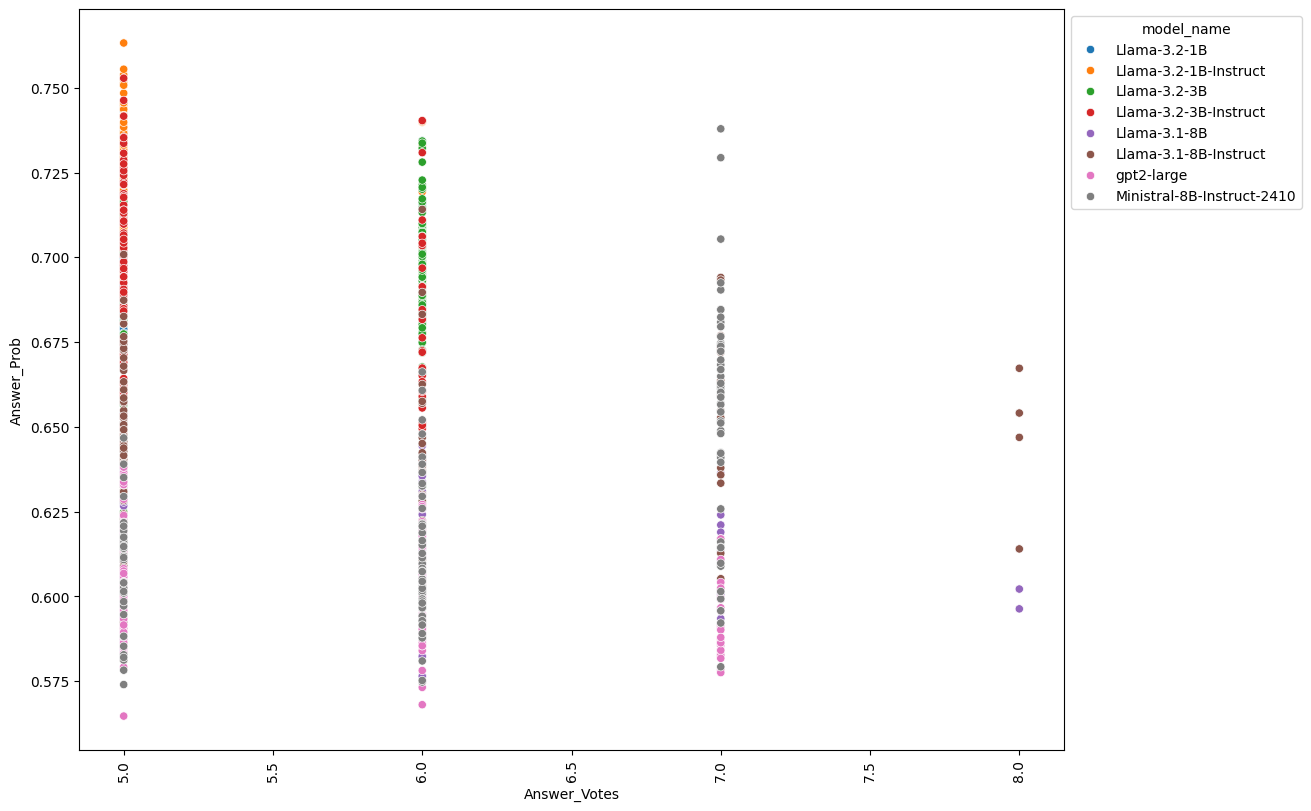

In [63]:
fig, ax = plt.subplots(1,1, figsize=(13,8), layout='constrained')
plt.xticks(rotation=90)
prob_measures = item_measures.copy()
prob_measures["Answer_Votes"] = item_measures["Answer_Votes"] * item_measures["Answer_Prob"]
ax = sns.scatterplot(
    x='Answer_Votes',
    y='Answer_Prob',
    hue="model_name",
    data=item_measures
)
sns.move_legend(ax, "upper left",  bbox_to_anchor=(1, 1))

# Choosing Models based on metrics

# With non-relative model measures

In [25]:
item_measures

,title,version,model_name,Answer_Mode,Answer_Votes,Answer_Prob,name
0,Emergency Damages I,unambiguous_uncovered,Llama-3.2-1B,Covered,5,0.681221,Emergency Damages I unambiguous_uncovered
1,Emergency Damages I,unambiguous_covered,Llama-3.2-1B,Covered,5,0.689016,Emergency Damages I unambiguous_covered
2,Emergency Damages I,controversial,Llama-3.2-1B,Covered,5,0.691620,Emergency Damages I controversial
3,Emergency Damages II,unambiguous_uncovered,Llama-3.2-1B,Covered,5,0.715439,Emergency Damages II unambiguous_uncovered
4,Emergency Damages II,unambiguous_covered,Llama-3.2-1B,Covered,5,0.699557,Emergency Damages II unambiguous_covered
...,...,...,...,...,...,...,...
1099,Vehicle Glass I,unambiguous_covered,Ministral-8B-Instruct-2410,NotCovered,6,0.591544,Vehicle Glass I unambiguous_covered
1100,Vehicle Glass I,controversial,Ministral-8B-Instruct-2410,NotCovered,5,0.614691,Vehicle Glass I controversial
1101,Vehicle Glass II,unambiguous_uncovered,Ministral-8B-Instruct-2410,NotCovered,7,0.651131,Vehicle Glass II unambiguous_uncovered
1102,Vehicle Glass II,unambiguous_covered,Ministral-8B-Instruct-2410,NotCovered,6,0.575185,Vehicle Glass II unambiguous_covered


In [26]:
combined_df.groupby('model_name', as_index=False, sort=False)\
    .agg({'entropy': 'mean', 'Covered_prob' : 'mean'})

,model_name,entropy,Covered_prob
0,Llama-3.2-1B,0.934828,0.524502
1,Llama-3.2-1B-Instruct,0.953427,0.556168
2,Llama-3.2-3B,0.954129,0.539358
3,Llama-3.2-3B-Instruct,0.947137,0.471598
4,Llama-3.1-8B,0.870718,0.529919
5,Llama-3.1-8B-Instruct,1.012425,0.449037
6,gpt2-large,0.911801,0.524485
7,Ministral-8B-Instruct-2410,1.021244,0.452325


In [27]:
combined_df

,index,title,prompt_type,prompt,version,output,output_text,cum_logprob,Yes_probs,No_probs,...,Aff_prob,UnAff_prob,Covered_prob,NotCovered_prob,Covered,NotCovered,Answer,Answer_prob,entropy,model_name
0,0,Emergency Damages I,yes_or_no,"Joanne's home insurance covers ""Emergency Dama...",unambiguous_uncovered,It,It depends.,NaN,0.124220,0.084340,...,0.124220,0.084340,0.595607,0.404393,True,False,Covered,0.595607,0.652769,Llama-3.2-1B
1,1,Emergency Damages I,yes_or_no,"Joanne's home insurance covers ""Emergency Dama...",unambiguous_covered,It,It depends.,NaN,0.148316,0.089958,...,0.148316,0.089958,0.622459,0.377541,True,False,Covered,0.622459,0.707022,Llama-3.2-1B
2,2,Emergency Damages I,yes_or_no,"Joanne's home insurance covers ""Emergency Dama...",controversial,It,It depends.,NaN,0.160527,0.094369,...,0.160527,0.094369,0.629775,0.370225,True,False,Covered,0.629775,0.735645,Llama-3.2-1B
3,3,Emergency Damages II,yes_or_no,"Salma's home insurance covers ""Emergency Damag...",unambiguous_uncovered,It,It depends.,NaN,0.210292,0.091870,...,0.210292,0.091870,0.695958,0.304042,True,False,Covered,0.695958,0.798287,Llama-3.2-1B
4,4,Emergency Damages II,yes_or_no,"Salma's home insurance covers ""Emergency Damag...",unambiguous_covered,It,It depends.,NaN,0.177080,0.094332,...,0.177080,0.094332,0.652439,0.347561,True,False,Covered,0.652439,0.759970,Llama-3.2-1B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9931,1237,Vehicle Glass I,options_flipped,Ahmad's car insurance policy includes coverage...,unambiguous_covered,A,A. Ahmad is not covered.,NaN,0.000943,0.000755,...,0.367305,0.288301,0.560253,0.439747,True,False,Covered,0.560253,0.943401,Ministral-8B-Instruct-2410
9932,1238,Vehicle Glass I,options_flipped,Ahmad's car insurance policy includes coverage...,controversial,A,A. Ahmad is not covered.,NaN,0.000702,0.000770,...,0.320318,0.308047,0.509764,0.490236,True,False,Covered,0.509764,0.934680,Ministral-8B-Instruct-2410
9933,1239,Vehicle Glass II,options_flipped,Aneesh's car insurance policy includes coverag...,unambiguous_uncovered,A,A. Aneesh is not covered.,NaN,0.000535,0.000439,...,0.183956,0.477146,0.278257,0.721743,False,True,NotCovered,0.721743,0.907754,Ministral-8B-Instruct-2410
9934,1240,Vehicle Glass II,options_flipped,Aneesh's car insurance policy includes coverag...,unambiguous_covered,Aneesh,Aneesh is covered.,NaN,0.000815,0.000391,...,0.297027,0.331358,0.472683,0.527317,False,True,NotCovered,0.527317,0.934112,Ministral-8B-Instruct-2410


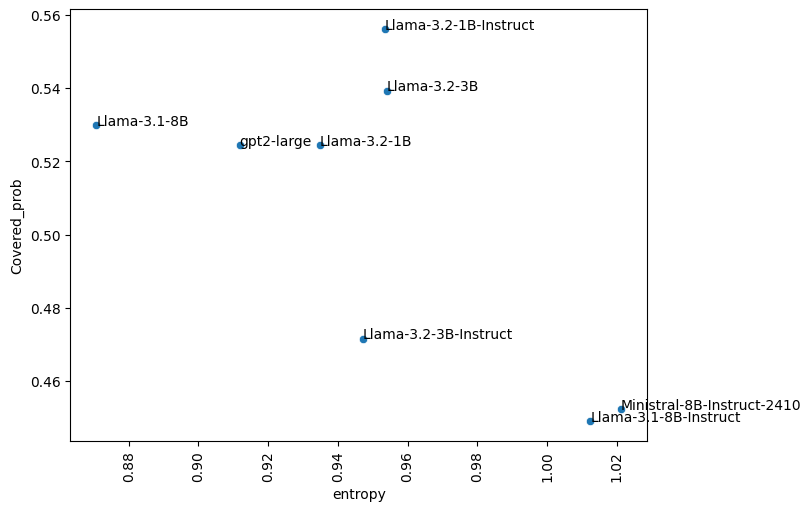

In [28]:
fig, ax = plt.subplots(1,1, figsize=(8,5), layout='constrained')
plt.xticks(rotation=90)
sample_measures = combined_df.groupby('model_name', as_index=False, sort=False)\
    .agg({'entropy': 'mean', 'Covered_prob' : 'mean'})
g = sns.scatterplot(
    x='entropy',
    y='Covered_prob',
    data=sample_measures
)
# sns.move_legend(ax, "upper left",  bbox_to_anchor=(1, 1))
def label_point(ax, data):
    for i, row in data.iterrows():
        ax.text(row.entropy, row.Covered_prob, row.model_name)
label_point(g, sample_measures)

In [29]:
leaderboard = relative_measures.groupby('model_name', sort=False, as_index=False).agg(
    {'js_dist': 'mean',
     'more_than_reversal': 'sum',
     'cond_entropy': 'mean'
    }
)
leaderboard

,model_name,js_dist,more_than_reversal,cond_entropy
0,Llama-3.2-1B,0.172040,460.0,0.604720
1,Llama-3.2-1B-Instruct,0.265191,17.0,0.428522
2,Llama-3.2-3B,0.162331,160.0,0.729235
3,Llama-3.2-3B-Instruct,0.210090,838.0,0.794418
4,Llama-3.1-8B,0.082755,944.0,0.843210
5,Llama-3.1-8B-Instruct,0.178282,199.0,0.723557
6,gpt2-large,0.116326,350.0,0.904226
7,Ministral-8B-Instruct-2410,0.112265,557.0,0.952921


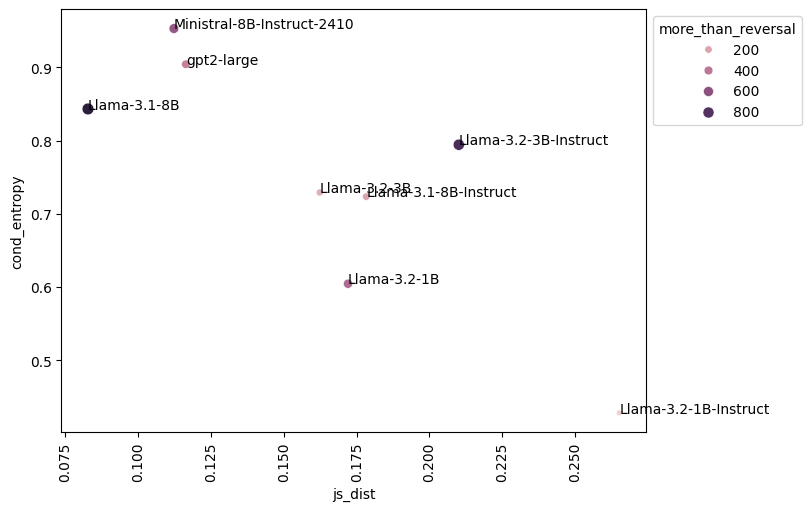

In [30]:
fig, ax = plt.subplots(1,1, figsize=(8,5), layout='constrained')
plt.xticks(rotation=90)
g = sns.scatterplot(
    x = 'js_dist', 
    y = 'cond_entropy',
    size = 'more_than_reversal',
    hue='more_than_reversal',
    data=leaderboard
)
sns.move_legend(ax, "upper left",  bbox_to_anchor=(1, 1))
def label_point(ax, leaderboard):
    for i, row in leaderboard.iterrows():
        ax.text(row.js_dist, row.cond_entropy, row.model_name)
label_point(g, leaderboard)

# Majority Voting with Confidence

In [34]:
item_measures.columns

Index(['title', 'version', 'model_name', 'Answer_Mode', 'Answer_Votes',
       'Answer_Prob'],
      dtype='object')

In [ ]:
item_measures 